In [37]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

print('슝=3')

슝=3


In [38]:
# deepLab model 불러오기
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 

model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

urllib.request.urlretrieve(model_url, model_file) 

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fe92e390b50>)

In [39]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [40]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [46]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [83]:

def  blurImg(img):
    # 원본 이미지 불러오기
    img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/' + img
    img_orig = cv2.imread(img_path) 

    # 크로마키 배경 이미지 불러오기
    img_path_chromakey = os.getenv('HOME')+'/aiffel/human_segmentation/images/ChromaKeyBackground.png' 
    img_chromakey = cv2.imread(img_path_chromakey) 
    height, width, _ = img_orig.shape
    img_chromakey = cv2.resize(img_chromakey, (width, height))
    
    print(img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

    segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

    #segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
    plt.imshow(output)
    plt.show()



    # 세그멘테이션 결과 후처리 (이미지 픽셀 개선)
    kernel = np.ones((5, 5), np.uint8)
    seg_map_processed = cv2.morphologyEx(output, cv2.MORPH_CLOSE, kernel)
#     seg_map_processed = output

    blurred_img = cv2.blur(img_orig, (30,30))

    # 블러 처리 반경 설정
    blur_radius = 25
    
   
    # object BGR
    object_color = None
    if ('person' in img):
        object_color = colormap[15][::-1] 
    elif ('cat' in img):
        object_color = colormap[8][::-1]
     

    # 객체와 배경 분리, 0과 1로 이진화
    object_mask = np.all(seg_map_processed == object_color, axis=-1) # person_mask = np.all(seg_map_processed == LABEL_NAMES.index('person'), axis=-1)

    # 'object' 이외의 모든 영역에 대한 마스크 생성 (object_mask의 반전), 0과 1로 이진화
    background_mask = np.logical_not(object_mask)
    plt.imshow(background_mask, cmap='gray',vmin=0, vmax=1)
    plt.show()

    # "object" 이외의 모든 라벨에 대해서만 블러 처리
    blurred_img = cv2.GaussianBlur(img_orig, (blur_radius, blur_radius), 0)
    img_concat = np.where(background_mask[..., np.newaxis], blurred_img, img_orig)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

    # 크로마키 이미지 
    img_concat_chromakey = np.where(background_mask[..., np.newaxis], img_chromakey, img_orig)
    plt.imshow(cv2.cvtColor(img_concat_chromakey, cv2.COLOR_BGR2RGB))
    plt.show()


(308, 480, 3)


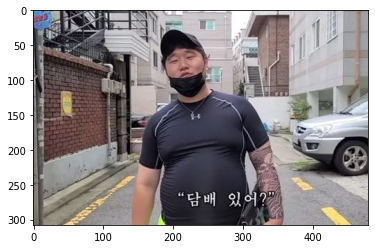

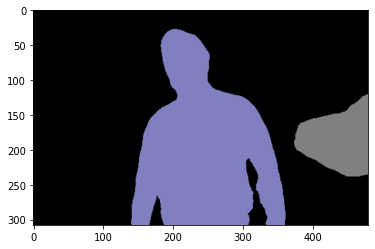

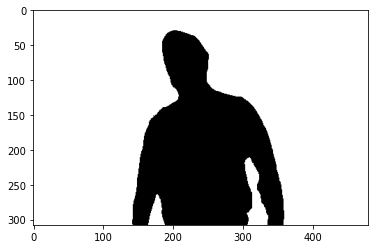

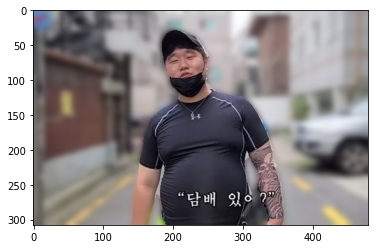

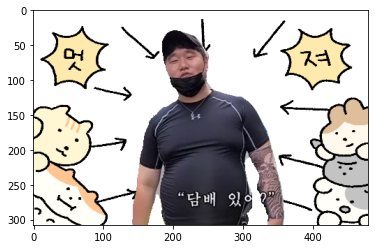

In [84]:
blurImg('person.jpeg')

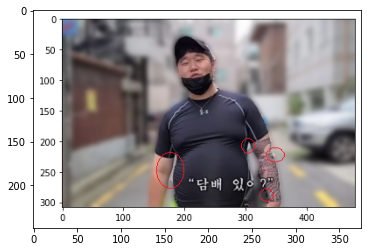

- 팔 사이, 몸 외곽선이 전반적으로 깔끔하게 분류되지 않는 문제점 발생
- 모폴로지 연산(후처리)으로 픽셀을 보정하였으나 눈에 띄는 변화가 없음

(720, 720, 3)


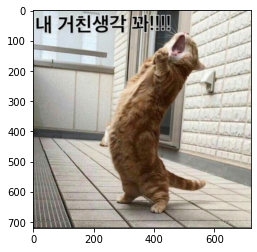

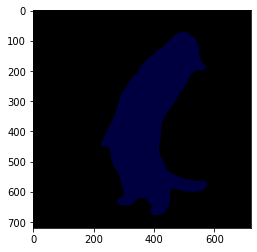

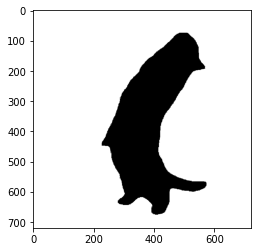

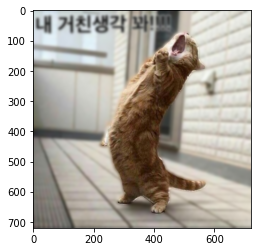

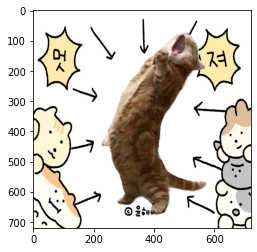

In [85]:
blurImg('cat.jpg')